In [14]:
import graph_tool.all as gt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import seaborn as sns
import numpy as np
import random

sns.set_style("whitegrid")
sns.set_palette(sns.color_palette('Set1'))

mpl.rcParams["font.size"] = 10
#mpl.rcParams["figure.figsize"] = [30, 20]

plt.show();
#pd.options.plotting.backend = 'plotly'

In [15]:
def plot_distribution(ax, graph, label):
    h = gt.vertex_hist(graph, 'out')
    ax[0].set_xlabel("Grau do vértice")
    ax[0].set_ylabel("Razão de ocorrência")
    ax[0].set_title("Distribuição de grau")

    ax[0].plot(h[1][:-1], h[0], label=label);
    #start, end = ax[0].get_xlim()
    ax[0].set_xticks(np.arange(1, h[1].max(),int(h[1].max()//10)))
    ax[0].get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax[0].legend()
    
    a = gt.assortativity(graph, "total")[0]
    corr = gt.avg_neighbor_corr(graph, "out", "out")
    ax[1].errorbar(corr[2][:-1], corr[0], yerr=corr[1], fmt="o-", label= f"{label}({a:.2f})")
    ax[1].legend(fontsize=10);
    ax[1].set_title("Grau médio dos vizinhos");
    ax[1].set_ylabel(r"$\left<k_{nn}\right>$");
    ax[1].set_xlabel("$k$");

In [16]:
def forge_prob(dmax, prob='assort'):
    if prob == 'assort':
        def assort(i, k):
            #a = 1-(abs(i-k)/dmax)
            a = 1.0 / (1 + abs(i - k))
            return a
        return assort
    elif prob == 'forced':
        def forced(i, k):
            return 0.95 if i == k else 0.05
        return forced
    else:
        def disassort(i, k):
            a = abs(i-k)/dmax
            return a
        return disassort

def deg_sample(lamb=2):
    return random.paretovariate(lamb)

# Montagem das redes artificiais

- Distribuição de grau deve seguir uma _Powerlaw_.
- Deve ser possível variar a correlação de grau.

## Como?

Utilizando uma função de Pareto, um amostrador é capaz de amostrar o grau dos vértices a serem adicionados de forma a gerar uma distribuição seguindo a Lei de Potência.

## Como variar a correlação de grau?

É necessário criar funções capazes de definir a probabilidade de conexão dos vértices segundo seu grau. A ideia é que a função seja capaz de reconectar os vértices formando correlações de grau mais específicas.

Para redes disassortativas:
$$
P(i,k) \propto \frac{|i-k|}{dmax}
$$
- $i, k$ grau do par de vértices analisado
- $dmax$ grau máximo de um vértice da rede


Já para redes assortativas:
$$
P(i,k) \propto \frac{1}{1+|i-k|}
$$

Gerando a rede _original_ utilizando apenas o amostrador de grau formou-se a rede com assortativade praticamente nula, ou seja, $r=0$. As funções de probabilidade utilizadas para reconexão dos vértices são funcionais, mas com proporção levemente diferente, como pode ser visto nas redes _Assortativa_ e _Disassortativa_ nos gráficos abaixo. Os valores da assortatividade constam entre parênteses.

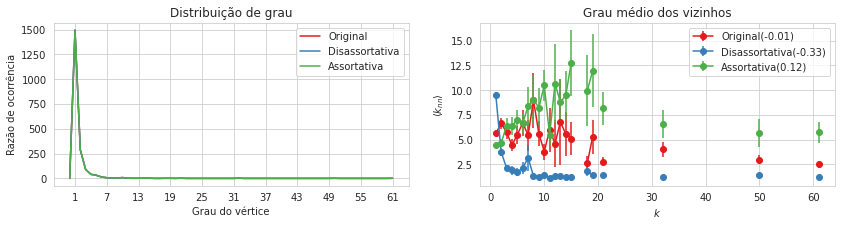

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14,3))
g = gt.random_graph(2000, lambda: deg_sample(2), directed=False)
plot_distribution(ax, g, 'Original')

probed = forge_prob(g.get_out_degrees(g.get_vertices()).max(), 'disassort')
ng = g.copy()
ret = gt.random_rewire(ng, "probabilistic-configuration", 
                       edge_probs=probed,
#                       #edge_probs = lambda i, k: 0.95 if i != k else 0.05,
                       edge_sweep=True, n_iter=1000, persist=True)
plot_distribution(ax, ng, 'Disassortativa')

probed = forge_prob(g.get_out_degrees(g.get_vertices()).max(), 'assort')
ngg = g.copy()
ret = gt.random_rewire(ngg, "probabilistic-configuration", 
#                      #edge_probs=lambda i, k: 1.0 / (1 + abs(i - k)),
                       #edge_probs=lambda i, k: 0.95 if i == k else 0.05,
                       edge_probs=probed,
                       edge_sweep=True, n_iter=1000, persist=True)
plot_distribution(ax, ngg, 'Assortativa')

A formação da redes assortativas ficou dificultada, aparentemente, devido ao alto número vértices com grau muito baixo e os poucos vértices com grau mais elevado. Assim, o ajuste de função de probabilidade se viu dificultada, pois seriam necessárias várias varreduras para encontrar vértices de grau maior e que existem em menor quantidade para que pudessem se unir.

Com isso, criou-se uma função arbitrária e mais radical a conectividade dos vértices e dada por:

$$
P(i, k) =
\begin{cases} 
0.95 & \text{se } i = k \\
0.05 & \text{se } i \neq k \\ 
\end{cases}
$$

Desta forma, viu-se resultados mais proporcionais. Note a função de nome _Assort. forçada_.

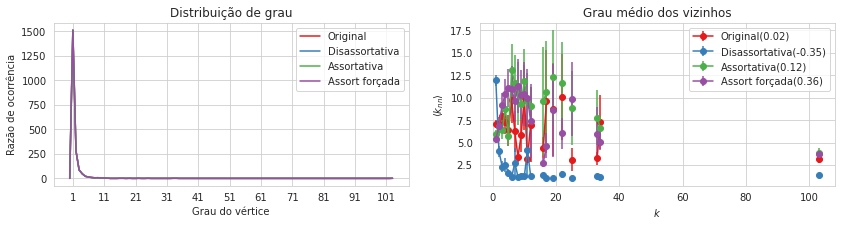

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(14,3))
g = gt.random_graph(2000, lambda: deg_sample(), directed=False)
plot_distribution(ax, g, 'Original')

probed = forge_prob(g.get_out_degrees(g.get_vertices()).max(), 'disassort')
ng = g.copy()
ret = gt.random_rewire(ng, "probabilistic-configuration", 
                       edge_probs=probed,
#                       #edge_probs = lambda i, k: 0.95 if i != k else 0.05,
                       edge_sweep=True, n_iter=1000, persist=True)
plot_distribution(ax, ng, 'Disassortativa')

probed = forge_prob(g.get_out_degrees(g.get_vertices()).max(), 'assort')
ngg = g.copy()
ret = gt.random_rewire(ngg, "probabilistic-configuration", 
#                      #edge_probs=lambda i, k: 1.0 / (1 + abs(i - k)),
                       #edge_probs=lambda i, k: 0.95 if i == k else 0.05,
                       edge_probs=probed,
                       edge_sweep=True, n_iter=1000, persist=True)
plot_distribution(ax, ngg, 'Assortativa')


probed = forge_prob(g.get_out_degrees(g.get_vertices()).max(), 'forced')
nggg = g.copy()
ret = gt.random_rewire(nggg, "probabilistic-configuration", 
                       edge_probs=probed,
                       edge_sweep=True, n_iter=1000, persist=True)
plot_distribution(ax, nggg, 'Assort forçada')